## Deep Q-Network (DQN)

Deep Q-Network (DQN) is a neural network (deep learning) method, which idea is strongly motivated by plain Q-learning.

As we saw in tabular Q-Learning,  Q-tables become computationally unfeasible when we have a larger observation (up to a continuous space) and action space.
To address this concern, in deep Q-learning algorithm, we apply a Q-function instead of Q-table to get the optimal action for the current state. The Q-function can be seen as an approximation of the Q-table. We implement the Q-function by building neural networks (deep learning), called Q-network.

![Q-Network](../assets/q-network.png)

As in plain Q-Learning, we then optimize Q-network (instead of Q-table) iteratively with actual experiments. There exist several tricks to improve training stability in Deep Q-Network (DQN) algorithm.



In [1]:
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
def pick_sample():
  return random.randint(0, 1)

env = gym.make("CartPole-v1",render_mode='human')
for i in range(1):
  print("start episode {}".format(i))
  done = False
  s, _ = env.reset()
  while not done:
    a = pick_sample()
    s, r, term, trunc, _ = env.step(a)
    done = term or trunc
    print("action: {},  reward: {}".format(a, r))
    print("state: {}, {}, {}, {}".format(s[0], s[1], s[2], s[3]))

env.close()


start episode 0
action: 1,  reward: 1.0
state: 0.00476384162902832, 0.24087725579738617, -0.03328154236078262, -0.3333616852760315
action: 0,  reward: 1.0
state: 0.009581387042999268, 0.04624442011117935, -0.03994877636432648, -0.05135707929730415
action: 0,  reward: 1.0
state: 0.010506275109946728, -0.14828261733055115, -0.040975917130708694, 0.22845885157585144
action: 1,  reward: 1.0
state: 0.007540622726082802, 0.04740021750330925, -0.0364067405462265, -0.07686256617307663
action: 0,  reward: 1.0
state: 0.008488627150654793, -0.1471814215183258, -0.03794398903846741, 0.20411525666713715
action: 0,  reward: 1.0
state: 0.005544999148696661, -0.34174075722694397, -0.033861685544252396, 0.48459136486053467
action: 0,  reward: 1.0
state: -0.0012898164568468928, -0.5363689064979553, -0.024169858545064926, 0.7664127945899963
action: 0,  reward: 1.0
state: -0.01201719418168068, -0.7311498522758484, -0.008841602131724358, 1.0513936281204224
action: 0,  reward: 1.0
state: -0.0266401916742324

We start with the (Bellman equation) as discussed in Q-learning :

$$ Q^{*}(s_t,a_t) = r_t + \gamma \max_a{Q(s_{t+1},a)}$$

where $ Q^{*} $ means the optimal $ Q $ value.

We optimize this Q-function $ Q(\cdot) $ to minimize the difference between $ r_t + \gamma \max_a{Q(s_{t+1},a)} $ and $ Q(s_t,a_t) $ with epsilon-greedy sampling. 

However, in DQN, we separate a network for generating the target $ \max_a{Q(s_{t+1},a)} $ from the original Q-network $ Q(s_t,a_t) $. (See below picture.)<br>
Remember that we also only updated the value of current state $ s_t $ (not the next state $ s_{t+1} $) in the Q-Learning. If the target network is same as Q-network, the weights of target is also changed in optimization, and it will eventually lose the stability of training.  We would be getting closer to our target, but the target is also moving. It’s like chasing a moving target! This can lead to significant oscillation in training.
Therefore, the algorithm separates a target network to keep the weights of target network not updated (not trained) in optimization.  We’re getting closer to our target, but the target is also moving. It’s like chasing a moving target! This can lead to significant oscillation in training.


Every $ C $ updates, it then clone Q-network to obtain a new target network. i.e, The update of target Q-Network is delayed.

![2 networks in DQN](../assets/dqn-2-networks.png)

Thus we build 2 networks - Q-network and target Q-network - as follows.<br>
This network (PyTorch module) outputs 2 values, in which each value corresponds to the expected Q-value in each action.<br>

![DQN-Value](../assets/DQN-Q-value.jpg)
In this CartPole example, we have 2 actions (left or right) and it then outputs 2 corresponding values.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class QNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        outs = self.output(outs)
        return outs

q_model = QNet().to(device)
q_target_model = QNet().to(device)
q_target_model.load_state_dict(q_model.state_dict())
_ = q_target_model.requires_grad_(False)  # target q-network doen't need grad

In Q-Learning, we fed the sequential samples for each training (for optimizing Q-table).<br>
In DQN, to prevent from learning only for recent experiences and improve training stability, we use a replay memory (also called experience replay). The algorithm stores the last $ N $ experience tuples in this replay memory, and samples uniformly at random when performing updates.

In [4]:
class replayMemory:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []

    def add(self, item):
        if len(self.buffer) == self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append(item)

    def sample(self, sample_size):
        # sampling
        items = random.sample(self.buffer, sample_size)
        # divide each columns
        states   = [i[0] for i in items]
        actions  = [i[1] for i in items]
        rewards  = [i[2] for i in items]
        n_states = [i[3] for i in items]
        dones    = [i[4] for i in items]
        # convert to tensor
        states = torch.tensor(states, dtype=torch.float).to(device)
        actions = torch.tensor(actions, dtype=torch.int64).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float).to(device)
        n_states = torch.tensor(n_states, dtype=torch.float).to(device)
        dones = torch.tensor(dones, dtype=torch.float).to(device)
        # return result
        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)

memory = replayMemory(buffer_size=10000)

In DQN, we'll minimize MSE (mean square error) to optimize.<br>
In neural network, this value is called a loss and the network is then updated (optimized) to minimize a loss:

$$ L = E \left[ \left( \left( r_t + \gamma \max_a{Q(s_{t+1},a)} \right) - Q(s_t,a) \right)^2 \right] $$


However, when it's terminal state in episode, the next state doesn't exist and a loss becomes $ ( r_t - Q(s_t,a) )^2 $.<br>
So the final loss expression will become :

$$ L = E \left[ \left( \left( r_t + \gamma (1 - d_t) \max_a{Q(s_{t+1},a)} \right) - Q(s_t,a) \right)^2 \right] $$

where $d_t = 1$ if the episode is done, and $0$ otherwise.

> Note : CartPole returns "done" flag as termination (term) or truncation (trunc) separately.<br>
> When it fails and is terminated, it returns True in termination flag. When it reaches to max 500 actions, it returns True in truncation flag. 
> For this reason, we will set $d_t=1$ only when termination is True. (If we set $d_t=1$ in truncation, the q-value in this state will then be underestimated, even though it's successful.)

In [5]:
gamma = 0.99

opt = torch.optim.Adam(q_model.parameters(), lr=0.0005)

def optimize(states, actions, rewards, next_states, dones, double=False):
    #
    # Compute target
    #
    with torch.no_grad():
        if double:
            next_state_actions = q_model(next_states).max(1)[1]
            next_state_actions = next_state_actions.unsqueeze(-1)
            next_state_vals = q_target_model(next_states).gather(1,next_state_actions).squeeze(-1)    
        else:
    
            next_state_vals = q_target_model(next_states).max(1)[0]
            
       
        target_vals_masked = (1.0 - dones) * next_state_vals
        q_vals1 = rewards + gamma * target_vals_masked

    opt.zero_grad()

    #
    # Compute q-value
    #
    actions_one_hot = F.one_hot(actions, env.action_space.n).float()
    q_vals2 = torch.sum(q_model(states) * actions_one_hot, 1)

    #
    # Get MSE loss and optimize
    #
    loss = F.mse_loss(
        q_vals1.detach(),
        q_vals2,
        reduction="mean")
    loss.backward()
    opt.step()

Now let's put it all together and start training (optimizing Q-network). The Formal Algorithm can be seen in the following Figure: 

![Q-Network](../assets/DQN-algo.png)



As in Q-Learning we also apply epsilon-greedy strategy for sampling actions.<br>
When it always picks up random actions, the agent won't converge into the optimal behaviors. On contrary, when it always picks up the optimal action, it never explore the new actions and it won't then also converge into the optimal behaviors.<br>
With epsilon-greedy strategy, it explores new actions in early stage, but gradually picks up the optimal actions to train. (This strategy adjusts the trade-off between exploration and exploitation.)

In [6]:
sampling_size = 64 * 30
batch_size = 64

epsilon = 1.0
epsilon_decay = epsilon / 3000
epsilon_final = 0.1

env = gym.make("CartPole-v1")

# pick up action from q-network with greedy exploration
def pick_sample(s, epsilon):
    with torch.no_grad():
        # get optimal action,
        # but with greedy exploration (to prevent picking up same values in the first stage)
        if np.random.random() > epsilon:
            s_batch = torch.tensor(s, dtype=torch.float).to(device)
            s_batch = s_batch.unsqueeze(dim=0)  # to make batch with size=1
            q_vals_for_all_actions = q_model(s_batch)
            a = torch.argmax(q_vals_for_all_actions, 1)
            a = a.squeeze(dim=0)
            a = a.tolist()
        else:
            a = np.random.randint(0, env.action_space.n)
        return a

# evaluate current agent with no exploration
def evaluate():
    with torch.no_grad():
        s, _ = env.reset()
        done = False
        total = 0
        while not done:
            a = pick_sample(s, 0.0)
            s_next, r, term, trunc, _ = env.step(a)
            done = term or trunc
            total += r
            s = s_next
        return total

reward_records = []
for _ in range(15000):
    # Run episode till it picks up 500 samples
    # (All samples are stored in reply memory.)
    done = True
    for _ in range(500):
        if done:
            s, _ = env.reset()
            done = False
            cum_reward = 0

        a = pick_sample(s, epsilon)
        s_next, r, term, trunc, _ = env.step(a)
        done = term or trunc
        memory.add([s.tolist(), a, r, s_next.tolist(), float(term)])  # (see above note for truncation)
        cum_reward += r
        s = s_next

    # Init replay memory (without updates) till 2000 samples are filled
    if memory.length() < 2000:
        continue

    # Optimize Q-network with a batch from replay memory
    states, actions, rewards, n_states, dones = memory.sample(sampling_size)
    states = torch.reshape(states, (-1, batch_size, 4))
    actions = torch.reshape(actions, (-1, batch_size))
    n_states = torch.reshape(n_states, (-1, batch_size, 4))
    dones = torch.reshape(dones, (-1, batch_size))
    for j in range(actions.size(dim=0)):
        optimize(states[j], actions[j], rewards[j], n_states[j], dones[j], double=True)
    total_reward = evaluate()
    reward_records.append(total_reward)
    iteration_num = len(reward_records)
    print("Run iteration {} rewards {:3} epsilon {:1.5f}".format(iteration_num, total_reward, epsilon), end="\r")

    # Clone Q-network to obtain target
    if iteration_num % 50 == 0:
        q_target_model.load_state_dict(q_model.state_dict())

    # Update epsilon
    if epsilon - epsilon_decay >= epsilon_final:
        epsilon -= epsilon_decay

    # stop if reward mean > 495.0
    if np.average(reward_records[-200:]) > 495.0:
       break

env.close()
print("\nDone")

Run iteration 10796 rewards 500.0 epsilon 0.10000
Done


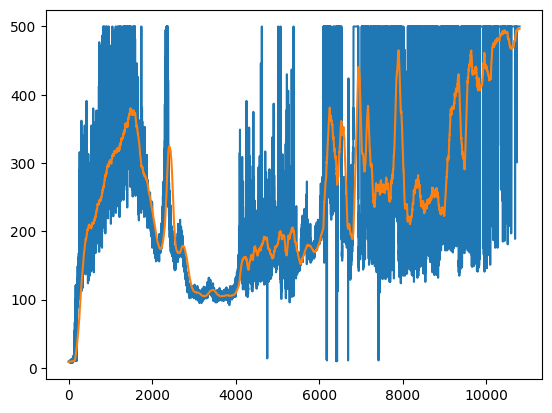

In [7]:
import matplotlib.pyplot as plt
# Generate recent 150 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 150:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-149:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)

## Additional Resources
- [Hugging Face Deep RL Course](https://huggingface.co/learn/deep-rl-course/unit3/introduction)
- [Pytorch Documentation](https://pytorch.org/docs/stable/index.html)